In [1]:
using LinearAlgebra
using Distributions
using Plots
using Random
using Optim

In [2]:
"""最小二乗法による多項式フィッティング"""
function polynomialfit(x, y, d)
    n = length(y)   # データサイズ
    X = x .^ (0:d)' # design matrix
    β̂ = X \ y       # Juliaでは X \ y の一発で最小二乗法が可能
    f(x) = evalpoly(x, β̂)
    ŷ = f.(x)
    r = ŷ - y
    σ̂ = norm(r)/√n  # モデルの標準偏差パラメータの推定
    dist = product_distribution([Normal(μ, σ̂) for μ in ŷ])
    loglik = logpdf(dist, y)  # 最大化された対数尤度
    AIC = -2loglik + 2(d + 2) # 所謂赤池情報量規準
    (; x, y, d, β̂, σ̂, f, loglik, AIC)
end

"""optimize函数を使った最尤法による多項式フィッティング"""
function polynomialfit_optim(x, y, d)
    negloglik(w) = begin
        β = @view w[1:end-1]
        σ = exp(w[end])
        n = length(y)
        dist = product_distribution([Normal(evalpoly(x[i], β), σ) for i in 1:n])
        -loglikelihood(dist, y)
    end
    o = optimize(negloglik, zeros(d+2))
    ŵ = o.minimizer
    β̂ = ŵ[1:end-1]
    σ̂ = exp(ŵ[end])
    loglik = -o.minimum
    AIC = 2o.minimum + 2(d + 2)
    f(x) = evalpoly(x, β̂)
    (; x, y, d, β̂, σ̂, f, loglik, AIC)
end

function plotpolyfit(result; legend=:topleft, titlefontsize=10, kwargs...)
    (; x, y, d, f, loglik, AIC) = result
    xs = range(extrema(x)...; length=1000)
    plot(; legend, titlefontsize)
    scatter!(x, y; label="data")
    plot!(xs, f.(xs); label="degree-$d fitting")
    title!("degree = $d,  log likelihood = $(round(loglik; digits=2)),  AIC = $(round(AIC; digits=2))")
    plot!(; kwargs...)
end

plotpolyfit (generic function with 1 method)

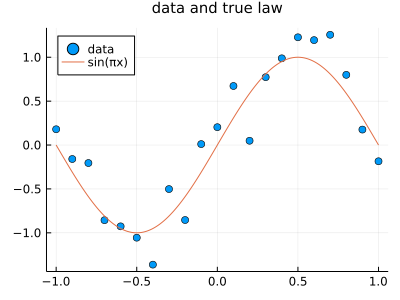

In [3]:
# データの生成

rng = MersenneTwister(1234567890)

x = range(-1, 1; length=21)
σ₀ = 0.3
noise = σ₀*randn(rng, length(x))
y = sinpi.(x) + noise

xs = range(extrema(x)...; length=1000)
P = plot(; legend=:topleft)
scatter!(x, y; label="data")
plot!(xs, sinpi.(xs); label="sin(πx)")
title!("data and true law"; titlefontsize=10)
plot!(; size=(400, 300))

In [4]:
β₀ = [isodd(k) ? (-1)^(k÷2)*π^k/factorial(k) : 0.0 for k in 0:3]
@show β₀ σ₀;

β₀ = [0.0, 3.141592653589793, 0.0, -5.167712780049969]
σ₀ = 0.3


In [5]:
(; β̂, σ̂, loglik, AIC) = polynomialfit(x, y, 3)
@show β̂ σ̂ loglik AIC;

β̂ = [0.04466351042287568, 2.946129545060222, 0.06296228110956492, -3.2531349243154093]
σ̂ = 0.2423950340353323
loglik = -0.03679245265333897
AIC = 10.073584905306678


In [6]:
(; β̂, σ̂, loglik, AIC) = polynomialfit_optim(x, y, 3)
@show β̂ σ̂ loglik AIC;

β̂ = [0.044664042617176186, 2.946130561054283, 0.06295618148421843, -3.2531403420379252]
σ̂ = 0.24239187726538136
loglik = -0.03679245802584674
AIC = 10.073584916051693


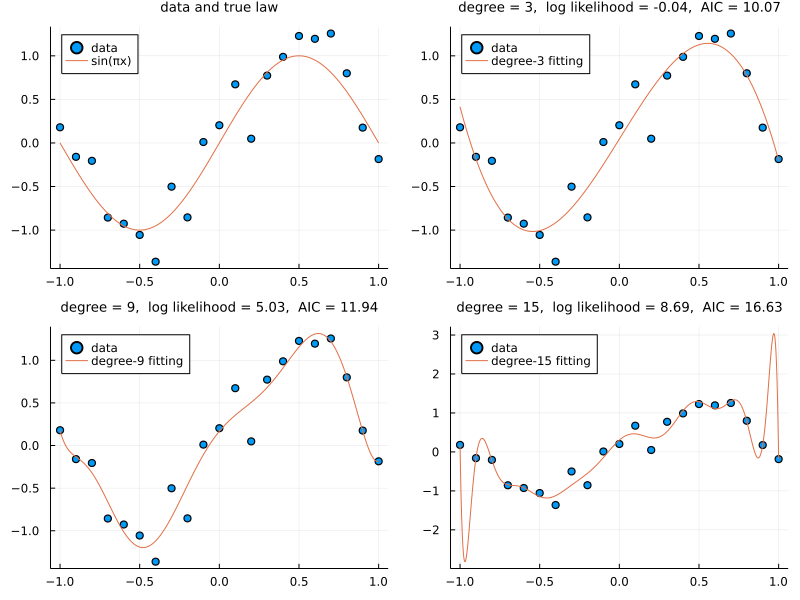

In [7]:
Q = plotpolyfit(polynomialfit(x, y, 3))
R = plotpolyfit(polynomialfit(x, y, 9))
S = plotpolyfit(polynomialfit(x, y, 15))

plot(P, Q, R, S; size=(800, 600), layout=(2, 2), titlefontsize=9)

対数尤度(log likelihood)の大きさは「もっともらしさ」の度合いではない！

対数尤度の大きさはモデルのデータへのフィッティングの良さの指標の1つに過ぎない。

上の結果を見れば分かるように、フィッティングで使う多項式の次数を上げた方がフィッティングの度合いが上がって、対数尤度も大きくなるが、次数が大きな場合の結果は全然「もっともらしい」とは言えない。

尤度を最大化することによってモデルのパラメータ値を調節する最尤法は「最も尤もらしいパラメータ値」を探すのではなく、単に「モデルをデータに最もフィットさせるようなパラメータ値」を探しているだけである。

最尤法は「最も尤もらしいパラメータ値」を探す方法ではない！

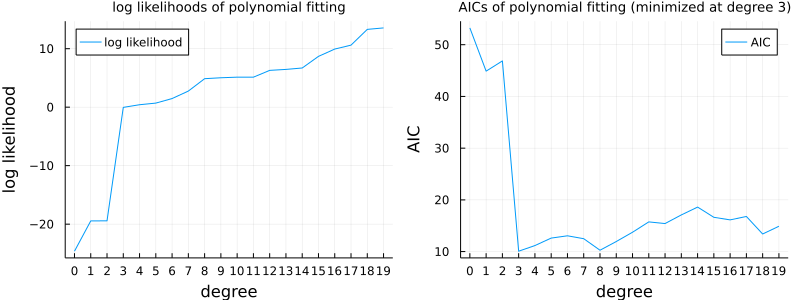

In [8]:
result = polynomialfit.(Ref(x), Ref(y), 0:19)
d = getproperty.(result, :d)
loglik = getproperty.(result, :loglik)
AIC = getproperty.(result, :AIC)
dbest = d[argmin(AIC)]

T = plot(d, loglik; label="log likelihood", legend=:topleft)
plot!(; xtick=d, xlabel="degree", ylabel="log likelihood")
title!("log likelihoods of polynomial fitting"; titlefontsize=10)

U = plot(d, AIC; label="AIC", legend=:topright)
plot!(; xtick=d, xlabel="degree", ylabel="AIC")
title!("AICs of polynomial fitting (minimized at degree $dbest)"; titlefontsize=10)

plot(T, U; size=(800, 300), titlefontsize=9, leftmargin=3Plots.mm, bottommargin=3Plots.mm)